In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)
data = pd.read_csv('data_pfas.csv', low_memory=False)
df = data.copy()
df = df[df['pfas_values'] != '[]']

In [3]:
def json_norm(df, column='pfas_values', dataset_id_column='dataset_id'):
   
    # Étape 1 : Appliquer json.loads si nécessaire et exploser les listes 'pfas_values'
    df_exploded = (
        df[[column, dataset_id_column]]  # Inclure 'dataset_id' lors de l'explosion
        .copy()
        .assign(pfas_values=lambda x: x[column].apply(lambda v: json.loads(v) if isinstance(v, str) else v))
        .explode(column)  # Exploser la colonne pour avoir une ligne par substance
    )

    # Étape 2 : Filtrer les lignes valides et normaliser les données JSON
    df_pfas = (
        df_exploded[df_exploded[column].notna()]  # Filtrer les lignes où 'pfas_values' n'est pas NaN
        .assign(pfas_values=lambda x: x[column].apply(lambda v: json.loads(v) if isinstance(v, str) else v))  # Appliquer json.loads si nécessaire
        .pipe(lambda x: pd.json_normalize(x[column]))  # Normaliser les données JSON en colonnes
    )

    # Étape 3 : Conserver l'index original et les valeurs de 'dataset_id'
    df_pfas['index_original'] = df_exploded[df_exploded[column].notna()].index

    # Dupliquer 'dataset_id' pour chaque ligne de 'pfas_values'
    df_pfas['dataset_id'] = df_exploded.loc[df_exploded[column].notna(), dataset_id_column].values

    return df_pfas


In [4]:
df_pfas = json_norm(df, column='pfas_values',  dataset_id_column='dataset_id')

In [5]:
df = df.merge(df_pfas,
              left_index=True, 
              right_on='index_original', 
              how='outer', 
              suffixes=('', '_json')
             )
# Suppression des colonnes doublons (suffixées avec '_json')
for col in df.columns:
    if col.endswith('_json'):
        original_col = col.replace('_json', '')
        # Vérifie que les deux colonnes existent avant de supprimer
        if original_col in df.columns and col in df.columns:
            df.drop(columns=[col], inplace=True)
df.drop(columns=['pfas_values'], inplace=True)

In [6]:
df.head(10)

,category,lat,lon,name,city,country,type,sector,source_type,source_text,source_url,dataset_id,dataset_name,unit,pfas_sum,details,matrix,date,year,cas_id,substance,value,isomer,less_than,index_original
0,Known,"50,808932","3,352552",Maes,Zwevegem,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,130,{},Surface water,NaN,2018.0,335-67-1,PFOA,90.0,NaN,NaN,12991
1,Known,"50,808932","3,352552",Maes,Zwevegem,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,130,{},Surface water,NaN,2018.0,1763-23-1,PFOS,40.0,NaN,NaN,12991
2,Known,"51,016507","4,088303",Tarkett,Dendermonde,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,200,{},Surface water,NaN,2017.0,335-67-1,PFOA,200.0,NaN,NaN,12992
3,Known,"51,042282","3,548967",Ververijen Escotex,Deinze,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,42400,{},Surface water,NaN,2016.0,335-67-1,PFOA,41400.0,NaN,NaN,12993
4,Known,"51,042282","3,548967",Ververijen Escotex,Deinze,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,42400,{},Surface water,NaN,2016.0,1763-23-1,PFOS,500.0,NaN,NaN,12993
5,Known,"51,042282","3,548967",Ververijen Escotex,Deinze,Belgium,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,42400,{},Surface water,NaN,2016.0,307-24-4,PFHxA,500.0,NaN,NaN,12993
6,Known,"51,771554","6,605953",Gerhard Van Clewe,Hamminkeln-Dingden,Germany,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,50,{},Surface water,NaN,2017.0,335-67-1,PFOA,30.0,NaN,NaN,12994
7,Known,"51,771554","6,605953",Gerhard Van Clewe,Hamminkeln-Dingden,Germany,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,50,{},Surface water,NaN,2017.0,1763-23-1,PFOS,20.0,NaN,NaN,12994
8,Known,"49,590101","7,603395",KOB Karl Otto Braun,Wolfstein,Germany,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,580,{},Surface water,NaN,2018.0,307-24-4,PFHxA,500.0,NaN,NaN,12995
9,Known,"49,590101","7,603395",KOB Karl Otto Braun,Wolfstein,Germany,Industrial site,Finishing of textiles,FOI,European Commission Joint Research Center,https://drive.google.com/drive/folders/1CKxJ5Q...,10,15 textile facilities emitting PFAS,ng/l,580,{},Surface water,NaN,2018.0,335-67-1,PFOA,80.0,NaN,NaN,12995


In [7]:
df['dataset_id'].value_counts().head()

dataset_id
29    1188235
16     828424
28     456549
54     314637
57     222640
Name: count, dtype: int64

In [50]:
data_29 = df.loc[(df['dataset_id'] == 29) | (df['dataset_id'] == 28)]
data_29['date'] = pd.to_datetime(data_29['date'], format='%Y-%m-%d')
data_29['cas_id'].value_counts()

C:\Users\User\AppData\Local\Temp\ipykernel_3632\793025263.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_29['date'] = pd.to_datetime(data_29['date'], format='%Y-%m-%d')


cas_id
1763-23-1      179834
335-67-1       151766
307-24-4       146492
355-46-4       145543
335-76-2       129149
375-85-9       119808
335-77-3       118020
375-95-1        80327
307-55-1        76530
2058-94-8       76059
754-91-6        49267
375-22-4        45772
2706-90-3       45478
72629-94-8      45471
375-73-5        44702
375-92-8        44439
376-06-7        43121
749786-16-1     17824
68259-12-1      17816
791563-89-8     17183
2706-91-4       17157
79780-39-5      17092
27619-97-2       2746
39108-34-4       2681
757124-72-4      2681
53826-12-3       2680
27854-31-5        705
70887-88-6        705
53826-13-4        705
70887-84-2        705
2991-50-6         632
2355-31-9         632
914637-49-3       325
2795-39-3         317
30334-69-1        199
70887-94-4        199
307-35-7           11
159381-10-9        11
Name: count, dtype: int64

In [52]:
data_29['pfas_sum'].value_counts()

pfas_sum
0       1058177
2         29324
1         25499
3         20064
4         12018
         ...   
1280          1
8630          1
1310          1
4130          1
2390          1
Name: count, Length: 2675, dtype: int64

In [54]:
PFOS_29 = data_29.loc[(data_29['cas_id'] == '1763-23-1') & ((data_29['less_than'] <= 4) | (data_29['value'].notna())) & (data_29['date'] >= '2014-01-01' )]

In [56]:
PFOS_29_top = PFOS_29[['lat', 'lon']].value_counts()[PFOS_29[['lat', 'lon']].value_counts() >= 150]
PFOS_29_top

lat        lon     
49,347886  0,565379    201
49,310144  1,236656    200
49,287347  1,209558    200
Name: count, dtype: int64

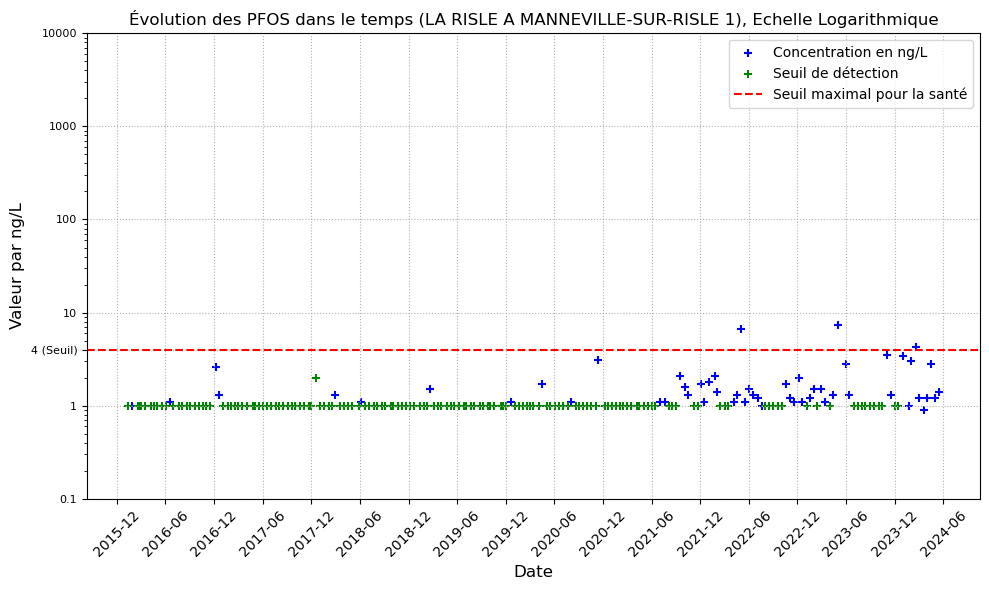

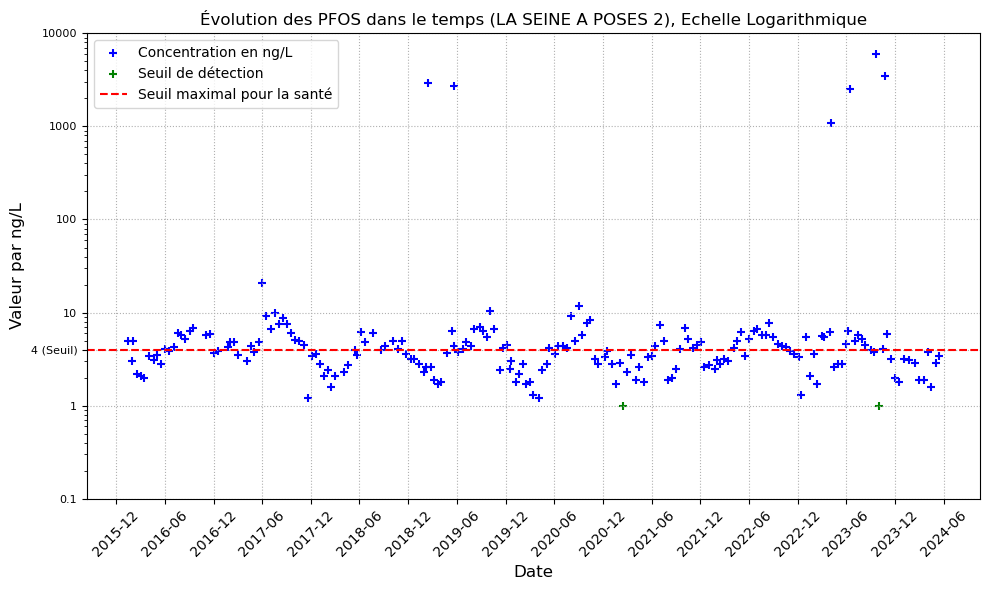

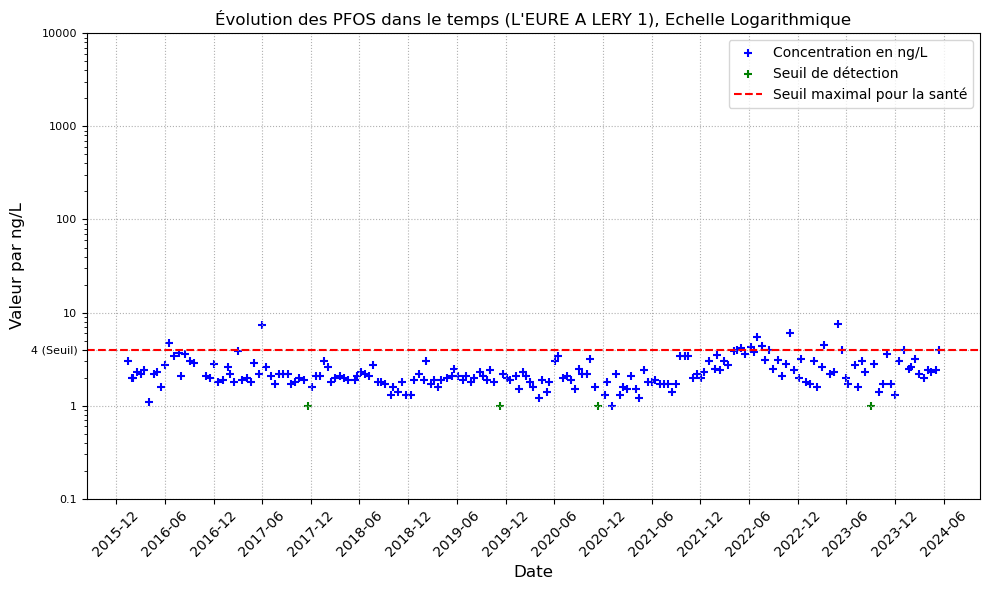

In [58]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter

# Boucle sur chaque combinaison de 'lat' et 'lon' dans PFOS_29_top
for (lat, lon), count in PFOS_29_top.items():
    # Filtrer les données pour la combinaison spécifique de 'lat' et 'lon'
    filtered_data = PFOS_29[(PFOS_29['lat'] == lat) & (PFOS_29['lon'] == lon)]
    
    # Si aucune donnée n'est trouvée pour la combinaison actuelle, passer à la suivante
    if filtered_data.empty:
        print(f"Pas de données pour la combinaison lat: {lat}, lon: {lon}")
        continue

    # Obtenir le nom du site ou, si la colonne 'name' n'existe pas, utiliser les coordonnées
    site_name = filtered_data['name'].iloc[0] if 'name' in filtered_data.columns else f"lat: {lat}, lon: {lon}"

    # Créer une nouvelle figure pour chaque combinaison de 'lat' et 'lon'
    plt.figure(figsize=(10, 6))

    # Tracer les points pour les valeurs non-nulles de la concentration
    if 'value' in filtered_data.columns:
        plt.scatter(filtered_data['date'][filtered_data['value'].notna()],
                    filtered_data['value'][filtered_data['value'].notna()],
                    marker='+', c='b', label='Concentration en ng/L')

    # Tracer les points pour les valeurs du seuil de détection
    if 'less_than' in filtered_data.columns:
        plt.scatter(filtered_data['date'][filtered_data['less_than'].notna()],
                    filtered_data['less_than'][filtered_data['less_than'].notna()],
                    marker='+', c='g', label='Seuil de détection')

    # Ajouter une ligne rouge horizontale pour indiquer le seuil maximal pour la santé
    plt.axhline(y=4, color='red', linestyle='--', label='Seuil maximal pour la santé')

    # Ajouter des titres et des labels aux axes
    plt.title(f'Évolution des PFOS dans le temps ({site_name}), Echelle Logarithmique', fontsize=12)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Valeur par ng/L', fontsize=12)
    plt.legend()

    # Ajuster l'échelle de l'axe Y en échelle logarithmique pour mieux visualiser les variations
    plt.yscale('log')

    # Formater les étiquettes de l'axe Y pour éviter la notation scientifique
    plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.gca().ticklabel_format(style='plain', axis='y', useOffset=False)

    # Définir manuellement les étiquettes principales de l'axe Y pour plus de clarté
    y_ticks = [0.1, 1, 4, 10, 100, 1000, 10000]
    y_labels = ['0.1', '1', '4 (Seuil)', '10', '100', '1000', '10000']
    
    plt.gca().set_yticks(y_ticks)
    plt.gca().set_yticklabels(y_labels)

    # Réduire la taille de police des étiquettes de l'axe Y pour éviter le chevauchement
    plt.tick_params(axis='y', labelsize=8)
    
    # Ajuster les étiquettes de l'axe X pour qu'elles apparaissent tous les 6 mois
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    # Faire pivoter les étiquettes de date pour une meilleure lisibilité
    plt.xticks(rotation=45)
    plt.grid(linestyle=':')
    plt.tight_layout()

    # Afficher le graphique
    plt.show()


In [87]:
import pandas as pd
import folium
import urllib.parse

# Filtrer les données correctement
# Sélectionne les lignes où 'cas_id' est '1763-23-1', 'less_than' est inférieur ou égal à 4, ou 'value' n'est pas nul,
# et où la date est postérieure ou égale au 1er janvier 2014
PFOS_29_map = data_29.loc[
    (data_29['cas_id'] == '1763-23-1') &  # Filtrer uniquement les enregistrements avec 'cas_id' spécifique
    ((data_29['less_than'] <= 4) | (data_29['value'].notna())) &  # Garder les enregistrements où 'less_than' est inférieur ou égal à 4, ou où 'value' n'est pas nul
    (data_29['date'] >= '2022-01-01') &  # Garder les enregistrements à partir du 1er janvier 2022
    (data_29['unit'] == 'ng/l') # Gaarder les donnée en Litre
]

# Ajouter une colonne 'value_combined' qui inclut 'value' ou 'less_than' lorsque 'value' est manquant
PFOS_29_map['value_combined'] = PFOS_29_map.apply(lambda row: row['value'] if pd.notna(row['value']) else row['less_than'], axis=1)

# Compter les occurrences de chaque combinaison de 'lat' et 'lon'
PFOS_29_map_grouped = PFOS_29_map.groupby(['lat', 'lon', "name"]).agg(
    matrix=('matrix', 'first'),  # Utiliser 'first' pour garder la valeur de "matrix"
    count=('lat', 'size'),       # Compter le nombre de prélèvements
    average_value=('value_combined', 'mean')  # Calculer la moyenne de "value_combined"
).reset_index()

# Convertir les coordonnées en type float et remplacer les virgules par des points
PFOS_29_map_grouped['lat'] = PFOS_29_map_grouped['lat'].apply(lambda x: float(str(x).replace(',', '.')))
PFOS_29_map_grouped['lon'] = PFOS_29_map_grouped['lon'].apply(lambda x: float(str(x).replace(',', '.')))



# Créer une carte centrée sur la France
m = folium.Map(location=[46.603354, 1.888334], zoom_start=6)  # Centrer la carte sur la France avec un niveau de zoom adapté

def generate_popup_content(site_data):
    avg_value_text = f"Valeur moyenne: {site_data['average_value']:.2f} ng/L" if not pd.isna(site_data['average_value']) else "Valeur moyenne: inférieur à 4 ng/L"
    return (
        f"<b style='font-size:14px;'>{site_data['name']}</b>"
        f"<br>Source des prélèvements : {site_data['matrix']}"
        f"<br>Nombre de prélèvements: {int(site_data['count'])}<br>{avg_value_text}"
        f"<br>Latitude: {site_data['lat']:.6f}<br>Longitude: {site_data['lon']:.6f}"
        f"<br><a href='/details/{urllib.parse.quote(site_data['name'])}' target='_blank'>Voir les détails</a>"
    )


# Ajouter les points des sites PFOS en utilisant `apply` pour améliorer les performances
def add_circle_marker(site_data):
    # Définir la couleur et l'opacité en fonction de la valeur moyenne
    if pd.isna(site_data['average_value']) or site_data['average_value'] < 4:
        color = 'blue'
        fill_opacity = 0.4  
        line_opacity = 0.4  
    elif 4 <= site_data['average_value'] < 10:
        color = 'yellow'
        fill_opacity = 0.8
        line_opacity = 0.8
    elif 10 <= site_data['average_value'] < 100:
        color = 'orange'
        fill_opacity = 0.8
        line_opacity = 0.8
    else:
        color = 'red'
        fill_opacity = 0.8
        line_opacity = 0.8

    popup_content = generate_popup_content(site_data)

    folium.CircleMarker(
        location=[site_data['lat'], site_data['lon']],  # Positionner le marqueur sur la latitude et la longitude données
        radius=2,  # Définir le rayon du marqueur
        color=color,  # Couleur du contour du marqueur
        opacity=line_opacity,  # Opacité du contour du marqueur
        fill=True,  # Activer le remplissage du marqueur
        fill_color=color,  # Couleur de remplissage du marqueur
        fill_opacity=fill_opacity,  # Opacité du remplissage
        popup=folium.Popup(popup_content, max_width=300)  # Ajouter le contenu du popup avec un titre en gras
    ).add_to(m)  # Ajouter le marqueur à la carte

# Utiliser apply pour ajouter les marqueurs
PFOS_29_map_grouped.apply(add_circle_marker, axis=1)

# Enregistrer la carte dans un fichier HTML
m.save("carte_france.html")  # Enregistrer la carte dans un fichier HTML
print("Carte enregistrée sous 'carte_france.html")  # Imprimer un message de confirmation


C:\Users\User\AppData\Local\Temp\ipykernel_3632\395694777.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PFOS_29_map['value_combined'] = PFOS_29_map.apply(lambda row: row['value'] if pd.notna(row['value']) else row['less_than'], axis=1)


Carte enregistrée sous 'carte_france.html


In [88]:
PFOS_29_map.to_csv('PFOS_29_map.csv', index=False)

In [71]:
df_france = df[df['country'] == "France"]
df_france['dataset_id'].value_counts()

dataset_id
29     1188235
28      456549
124      27441
31       15628
30        4590
12         289
13          14
Name: count, dtype: int64

In [73]:
df_france_31 = df_france.loc[(df_france['dataset_id'] == 31)]
df_france_31

,category,lat,lon,name,city,country,type,sector,source_type,source_text,source_url,dataset_id,dataset_name,unit,pfas_sum,details,matrix,date,year,cas_id,substance,value,isomer,less_than,index_original
2571338,Known,"47,73434","7,04102",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,0,"{""codequalitometre"": 949.0, ""codeproducteur"": ...",Groundwater,2016-08-22,2016.0,2706-90-3,PFPeA,NaN,NaN,0.050,342086
2571339,Known,"47,73434","7,04102",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,0,"{""codequalitometre"": 949.0, ""codeproducteur"": ...",Groundwater,2016-08-22,2016.0,307-55-1,PFDoDA,NaN,NaN,0.025,342086
2571340,Known,"47,73434","7,04102",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,0,"{""codequalitometre"": 949.0, ""codeproducteur"": ...",Groundwater,2016-08-22,2016.0,2058-94-8,PFU(n)DA,NaN,NaN,0.025,342086
2571341,Known,"47,73434","7,04102",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,0,"{""codequalitometre"": 949.0, ""codeproducteur"": ...",Groundwater,2016-08-22,2016.0,335-76-2,PFDA,NaN,NaN,0.005,342086
2571342,Known,"47,73434","7,04102",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,0,"{""codequalitometre"": 949.0, ""codeproducteur"": ...",Groundwater,2016-08-22,2016.0,335-77-3,PFDS,NaN,NaN,0.005,342086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2586961,Known,"49,38405","8,68197",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,"0,012","{""codequalitometre"": 9377.0, ""codeproducteur"":...",Groundwater,2016-09-12,2016.0,307-24-4,PFHxA,0.003,NaN,NaN,343097
2586962,Known,"49,38405","8,68197",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,"0,012","{""codequalitometre"": 9377.0, ""codeproducteur"":...",Groundwater,2016-09-12,2016.0,59933-66-3,Perfluorobutanesulfonic acid,0.002,NaN,NaN,343097
2586963,Known,"49,38405","8,68197",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,"0,012","{""codequalitometre"": 9377.0, ""codeproducteur"":...",Groundwater,2016-09-12,2016.0,355-46-4,PFHxS,0.001,NaN,NaN,343097
2586964,Known,"49,38405","8,68197",Sampling location,NaN,France,Sampling location,NaN,Authorities,Aprona,https://www.aprona.net/FR/ermes-rhin/presentat...,31,Rhine Aquifer,ng/l,"0,012","{""codequalitometre"": 9377.0, ""codeproducteur"":...",Groundwater,2016-09-12,2016.0,335-67-1,PFOA,0.001,NaN,NaN,343097
